In [1]:
from collections import Counter

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from convokit import Corpus, PolitenessStrategies, download
from nltk.corpus import stopwords
from scipy.special import softmax
from transformers import AutoConfig, AutoModelForSequenceClassification, \
    AutoTokenizer
%matplotlib inline

h:\moha\NLP\AM\SA\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extracting and Structuring Conversation Data Using ConvoKit and NLTK

In [2]:
# Load corpus from disk
corpus = Corpus(download("winning-args-corpus"))   #edit ti


In [4]:
corpus.conversations

{'t3_2ro9ux': Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x00000226B4D6D450>, 'id': 't3_2ro9ux', 'meta': ConvoKitMeta({'op-userID': 'seanyowens', 'op-text-body': 'I can\'t remember the topic that spurred this discussion, but a friend and I were debating whether man-made things were natural. He took the position that they are unnatural. \n\nHe cited this definition by Merriam-Webster:  existing in nature and not made or caused by people : coming from nature (http://www.merriam-webster.com/dictionary/natural) as his basis for the distinction for natural vs. unnatural.\n\nHowever, I respectfully disagree with his position and furthermore that definition of natural. People arise from nature. Humankind\'s capacity to create, problem-solve, analyze, rationalize, and build also come from natural processes. How are the things we create unnatural? It is only through natural occurrences that we have this ability, why is

In [5]:
def get_thread(corpus: Corpus, conv_id: str) -> pd.DataFrame:
    """
    Extracts and structures conversation data from a ConvoKit corpus for a given conversation ID.
    
    Args:
        corpus (Corpus): The ConvoKit corpus containing conversation data.
        conv_id (str): The conversation ID for which to extract the thread.
    
    Returns:
        pd.DataFrame: A DataFrame containing utterance ID, speaker, reply-to relationship, timestamp, and text for the conversation thread.
    """
    root_conversation = corpus.conversations[conv_id]

    # Loop through each utterance and collect necessary information
    thread_data = []
    for utt in root_conversation.iter_utterances():
        try:
            thread_data.append({
                'utterance_id': utt.id,
                'speaker'     : utt.speaker.id,
                'reply_to'    : utt.reply_to if utt.reply_to is not None 
                else utt.id,
                'timestamp'   : utt.timestamp if utt.timestamp is not None 
                else 0,
                'text'        : utt.text,
                'success'     : utt.meta['success'] if utt.meta['success'] 
                                                       is not None else -1 
            })
        except KeyError:
            continue

    # Create a DataFrame from the collected data and sort it
    df = pd.DataFrame(thread_data)
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    return df


# Get conversation IDs
convos = [i.id for i in corpus.iter_conversations()]

# Extract thread data for the first conversation
thread_df = get_thread(corpus, convos[0])
text = thread_df["text"][0]


In [6]:
thread_df

,utterance_id,speaker,reply_to,timestamp,text,success
0,t3_2ro9ux,seanyowens,t3_2ro9ux,0,I can't remember the topic that spurred this d...,-1
1,t1_cnhplrm,Account9726,t3_2ro9ux,1420697092,"Look at the definition you provided, if we rem...",1
2,t1_cnhpnmr,R3ptar1337,t3_2ro9ux,1420697175,"I agree with OP. To add to their points, if we...",-1
3,t1_cnhpp4o,BenIncognito,t3_2ro9ux,1420697241,&gt; People arise from nature. Humankind's cap...,-1
4,t1_cnhpsmr,seanyowens,t1_cnhplrm,1420697421,Maybe a new word is needed? Making such a dist...,1
5,t1_cnhpvqs,Account9726,t1_cnhpsmr,1420697567,"Okay, the new word is for this is swizlax. The...",-1
6,t1_cnhq330,Amablue,t3_2ro9ux,1420697904,Consider the definition of a prime number. It'...,-1
7,t1_cnhq7iw,seanyowens,t1_cnhpvqs,1420698102,Yeah I do see what you're saying. Thanks for t...,-1
8,t1_cnhq7nv,nikoberg,t3_2ro9ux,1420698109,People have already covered the main relevant ...,-1
9,t1_cnhqcwz,Nepene,t3_2ro9ux,1420698347,You're using natural to mean definition 8\n\n&...,0


In [7]:
text

'I can\'t remember the topic that spurred this discussion, but a friend and I were debating whether man-made things were natural. He took the position that they are unnatural. \n\nHe cited this definition by Merriam-Webster:  existing in nature and not made or caused by people : coming from nature (http://www.merriam-webster.com/dictionary/natural) as his basis for the distinction for natural vs. unnatural.\n\nHowever, I respectfully disagree with his position and furthermore that definition of natural. People arise from nature. Humankind\'s capacity to create, problem-solve, analyze, rationalize, and build also come from natural processes. How are the things we create unnatural? It is only through natural occurrences that we have this ability, why is it that we would give the credit of these things solely to man, as opposed to nature? We are not separate from nature, thus, how can any of our actions or creations be unnatural? If we were somehow separate from nature, I would understand

In [8]:
text2 = thread_df["text"][8]


In [9]:
text2

'People have already covered the main relevant point, in that the term "natural" serves a useful purpose in denoting things that are not man-made, but I would like to point out that the opposite of "natural" for this usage isn\'t "unnatural"- it\'s "artificial." \n\nThis might be the root of your intuition as to why you think man-made things are "natural." The term "unnatural" has a definition of "contrary to course of nature" or "abnormal." There is a value judgment here which says that non-human things are somehow pure, valuable, or simply otherwise separate from human affairs in a moral sense. When an environmentalist says that unnatural toxins are damaging the environment, what she means is not necessarily just that toxins are artificial, but that by producing them we are somehow upsetting the course of the universe. Similarly, when a fundamentalist says that homosexuality is "unnatural," he does not just mean that it is artificial in the sense of being created by society- he means

### Sentiment and Emotion Analysis of Words Using Hugging Face Models and NLTK

In [10]:
# Pre-trained models for emotion and sentiment
MODEL_EMO = "cardiffnlp/twitter-roberta-base-emotion-latest"
MODEL_SENT = "cardiffnlp/twitter-roberta-base-sentiment-latest"


def make_processors(hfmodel: str):
    """
    Load the model, tokenizer, and config from Hugging Face's pre-trained model.
    
    Args:
        hfmodel (str): Model name from Hugging Face hub.
        
    Returns:
        tuple: Tokenizer, configuration, and model for the given model.
    """
    tokenizer = AutoTokenizer.from_pretrained(hfmodel)
    config = AutoConfig.from_pretrained(hfmodel)
    model = AutoModelForSequenceClassification.from_pretrained(hfmodel,
                                                               ignore_mismatched_sizes=True)
    return tokenizer, config, model


# Initialize models and tokenizers
tokenizer_sent, config_sent, model_sent = make_processors(MODEL_SENT)
tokenizer_emo, config_emo, model_emo = make_processors(MODEL_EMO)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:

def get_word_sentiment(word: str) -> dict:
    """
    Analyze the sentiment of a word using a pre-trained sentiment model.
    
    Args:
        word (str): The word to analyze.
        
    Returns:
        dict: Sentiment scores for the word.
    """
    encoded_input = tokenizer_sent(word, return_tensors='pt', truncation=True,
                                   max_length=512)
    output = model_sent(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Rank scores
    ranking = np.argsort(scores)[::-1]

    # Prepare result
    result = {"word": word}
    for i in range(scores.shape[0]):
        label = config_sent.id2label[ranking[i]]
        result[label] = np.round(float(scores[ranking[i]]), 4)

    return result


def get_word_feelings(word: str) -> dict:
    """
    Analyze the emotion of a word using a pre-trained emotion model.
    
    Args:
        word (str): The word to analyze.
        
    Returns:
        dict: Emotion scores for the word.
    """
    encoded_input = tokenizer_emo(word, return_tensors='pt')
    output = model_emo(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Rank scores
    ranking = np.argsort(scores)[::-1]

    # Prepare result
    result = {"word": word}
    for i in range(scores.shape[0]):
        label = config_emo.id2label[ranking[i]]
        result[label] = np.round(float(scores[ranking[i]]), 4)

    return result


def get_feelings_for_words(words: list) -> pd.DataFrame:
    """
    Process a list of words to extract both their sentiment and emotion scores.
    
    Args:
        words (list): List of words to analyze.
        
    Returns:
        pd.DataFrame: DataFrame containing word, emotion, and sentiment scores.
    """
    data = []
    for word in words:
        feelings = get_word_feelings(word)
        sentiment = get_word_sentiment(word)
        combined = feelings | sentiment  # Merge both dictionaries
        data.append(combined)

    return pd.DataFrame(data)


def count_unique_words_nltk(text: str) -> Counter:
    """
    Tokenize a text and count the frequency of unique words, excluding stopwords and punctuation.
    
    Args:
        text (str): The text to process.
        
    Returns:
        Counter: A Counter object with word frequencies.
    """
    # Tokenize and clean the text
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))

    # Filter out stopwords and punctuation
    filtered_words = [word for word in words if
                      word not in stop_words and word.isalpha()]

    return Counter(filtered_words)


# Sample text processing (replace 'text' with your input text)
# Tokenize and count unique words
unique_word_counts_nltk = count_unique_words_nltk(text)

# Extract unique words (keys) from the Counter object
unique_words_raw = list(unique_word_counts_nltk.keys())

# Perform emotion and sentiment analysis on the unique words
df_raw = get_feelings_for_words(unique_words_raw)

### Split text using overlapping parts

In [26]:
from nltk.tokenize import word_tokenize, sent_tokenize


def recursive_text_splitter(text: str, max_words: int,
                            overlapping: int = 0) -> list:
    """
    Recursively split text by sentences and then by words, ensuring no chunk exceeds max_words.
    
    Args:
        text (str): The text to split.
        max_words (int): Maximum number of words allowed in a chunk.
        overlapping (int): Number of overlapping words between chunks. Default is 0.
    
    Returns:
        list: A list of text chunks.
    """
    # Tokenize text by sentences
    sentences = sent_tokenize(text)
    chunks = []

    # Split each sentence by words and create chunks
    for sentence in sentences:
        words = word_tokenize(sentence)

        # If the sentence has more than max_words, split it further
        if len(words) > max_words:
            # Iterate over the words to create chunks with overlapping words
            for i in range(overlapping, len(words), max_words - overlapping):
                # Define the chunk's start and end points
                start = max(0, i - overlapping) if i > 0 else i
                end = min(len(words), i + max_words)

                # Create a chunk and append it to the list
                chunk = words[start:end]
                chunks.append(' '.join(chunk))
        else:
            # If the sentence is small enough, add it as-is
            chunks.append(sentence)

    return chunks


# Example sentence
sentence = ("This is a wonderful day to go fishing today, although I can say "
            "that I do not feel very well, and I would prefer to stay at "
            "home, if this is okay with you.")

# Call the recursive_text_splitter function with a max_words of 10 and overlapping of 5
ngrams_list = recursive_text_splitter(sentence, 10, 5)

# Print the resulting chunks
for i, ngram in enumerate(ngrams_list):
    print(f"Chunk {i + 1}: {ngram}")

Chunk 1: This is a wonderful day to go fishing today , although I can say that
Chunk 2: to go fishing today , although I can say that I do not feel very
Chunk 3: although I can say that I do not feel very well , and I would
Chunk 4: I do not feel very well , and I would prefer to stay at home
Chunk 5: well , and I would prefer to stay at home , if this is okay
Chunk 6: prefer to stay at home , if this is okay with you .
Chunk 7: , if this is okay with you .


### Polarity per overlapping section

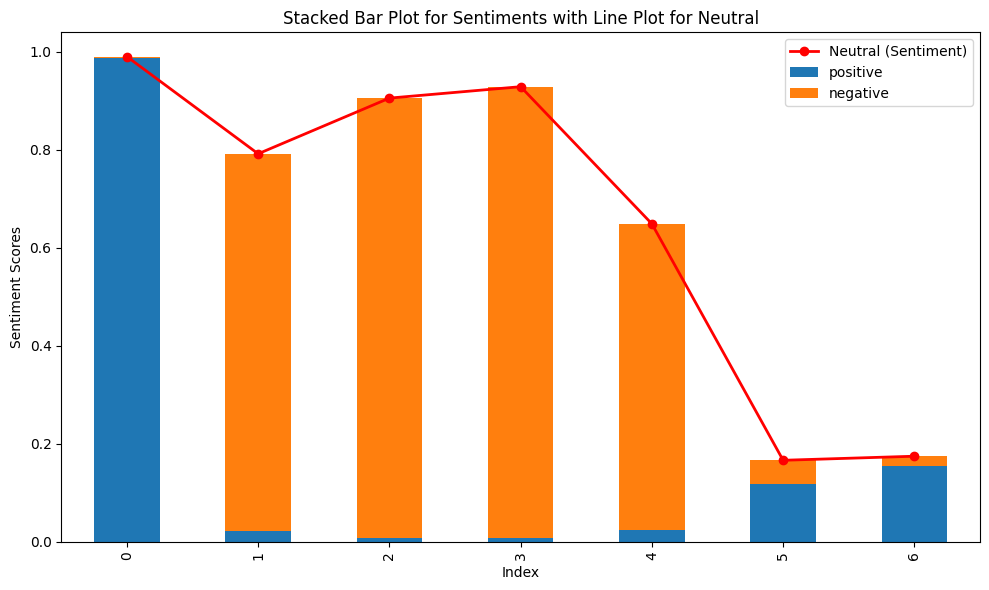

In [61]:
def plot_sentiment(input_df: pd.DataFrame,
                   keep_cols: list = None,
                   drop_cols: list = None,
                   neutral_col: str = None,
                   legend_out: bool = False):
    """
    Plots a stacked bar chart for selected sentiment columns and overlays a line plot for `1 - neutral`.
    
    Args:
        input_df (pd.DataFrame): DataFrame containing the sentiment data.
        keep_cols (list): List of columns to be included in the stacked bar 
        drop_cols (list): List of columns to be dropped. 
        neutral_col (str): Column name for the neutral sentiment (to plot 1 - neutral).
    
    Returns:
        None: Displays the plot.
    """
    # Stacked bar plot for the selected sentiment columns
    if keep_cols is None:
        keep_cols = input_df.columns.tolist()
    if drop_cols is None:
        drop_cols = []
    input_df[keep_cols].drop(columns=drop_cols).plot.bar(stacked=True,
                                                         figsize=(10, 6))

    # Line plot for `1 - neutral`
    if neutral_col is not None:
        plt.plot(input_df.index, 1 - input_df[neutral_col], color='red',
                 marker='o', label='Neutral (Sentiment)', linewidth=2)

    # Add legend and labels
    plt.legend(loc='best')
    plt.xlabel("Index")
    plt.ylabel("Sentiment Scores")
    plt.title("Stacked Bar Plot for Sentiments with Line Plot for Neutral")
    if legend_out:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.tight_layout()
    plt.show()


ngrams_list = recursive_text_splitter(sentence, 10, 5)
overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(overlapping_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Polarity per non overlapping sector

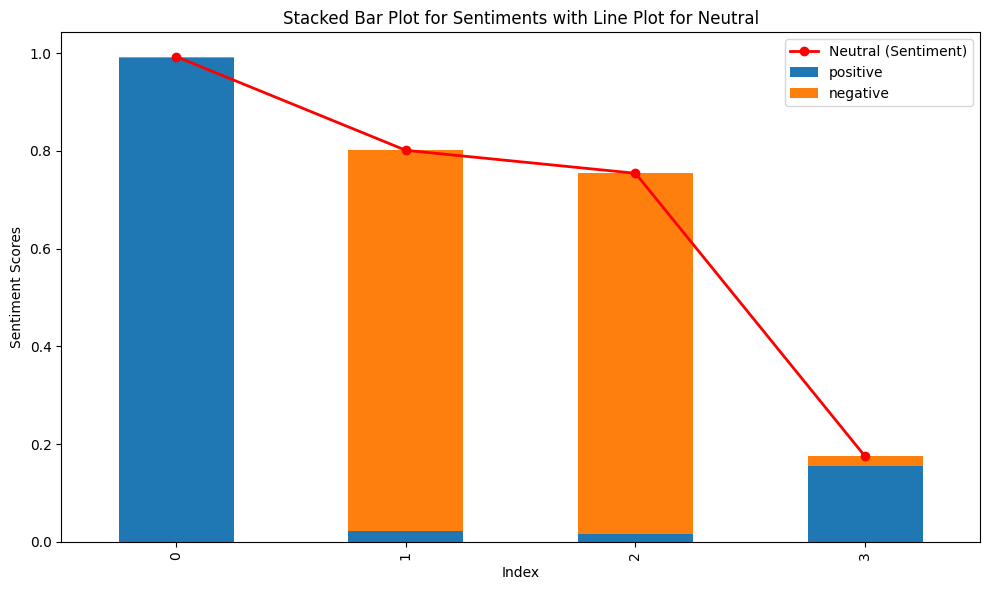

In [57]:
ngrams_list = recursive_text_splitter(sentence, 10, 0)
non_overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(non_overlapping_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Sentiments per overlapping sector

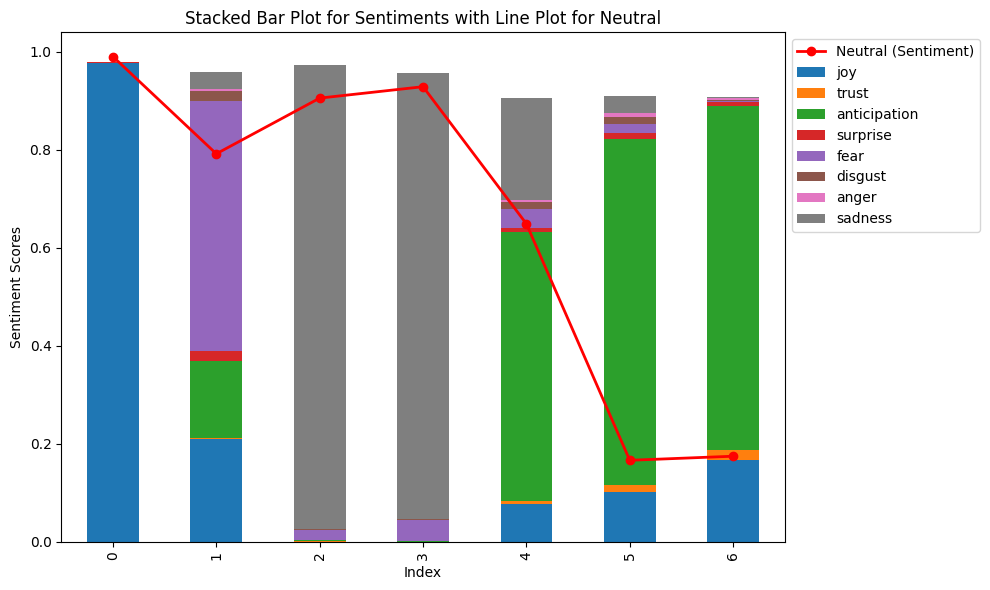

In [64]:
ngrams_list = recursive_text_splitter(sentence, 10, 5)
overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(overlapping_text_sample_df,
               drop_cols=["positive", "negative", "neutral", "love",
                          "pessimism", "optimism"],
               neutral_col="neutral",
               legend_out=True)



### Sentiment per word

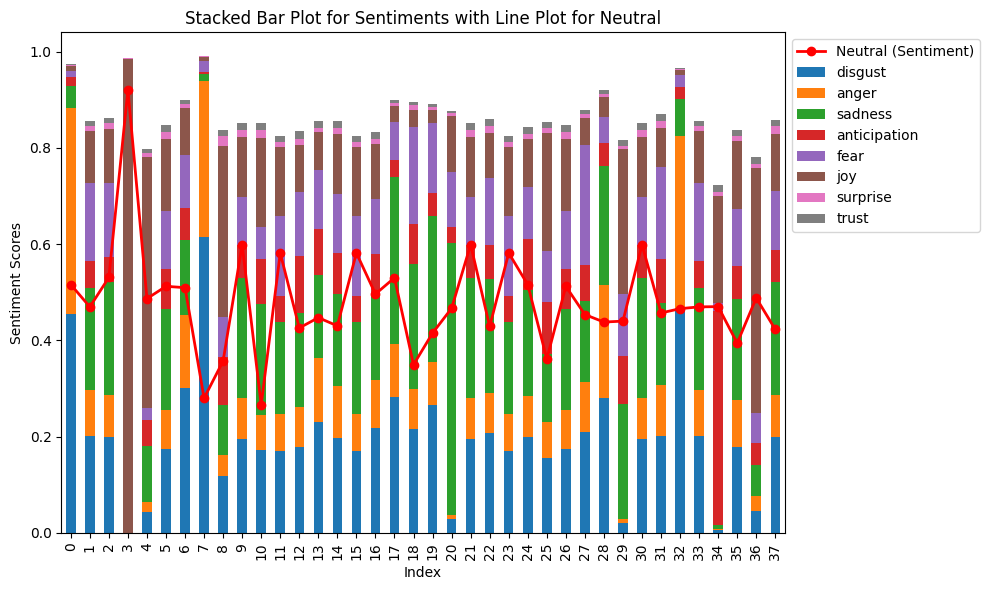

In [69]:
ngrams_list = word_tokenize(sentence)
overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(overlapping_text_sample_df,
               drop_cols=["positive", "negative", "neutral", "love",
                          "pessimism", "optimism"],
               neutral_col="neutral",
               legend_out=True)


### Polarity per word

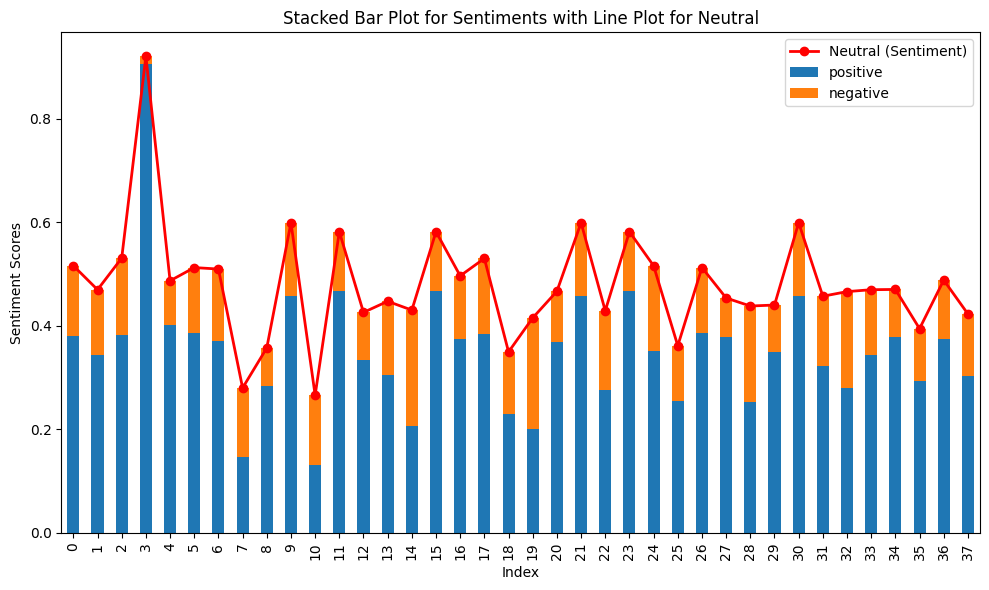

In [70]:
ngrams_list = word_tokenize(sentence)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

In [76]:
from nrclex import NRCLex

text_words = word_tokenize(sentence)
text_object = NRCLex(text=sentence)

print(f"There are {len(text_object.affect_dict.keys())} words in the "
      f"input text and the NRC: "
      f"{[key for key in text_object.affect_dict.keys()]}")


There are 2 words in the input text and the NRC: ['wonderful', 'prefer']


## TNLP with CMV
### Root argument

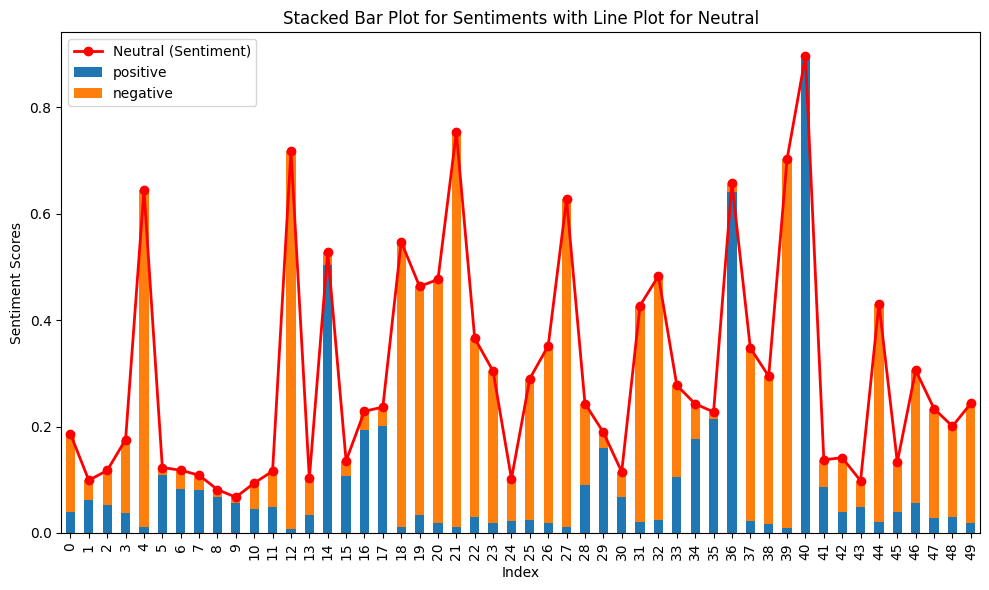

In [77]:
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 1 attacking the opinion of the root

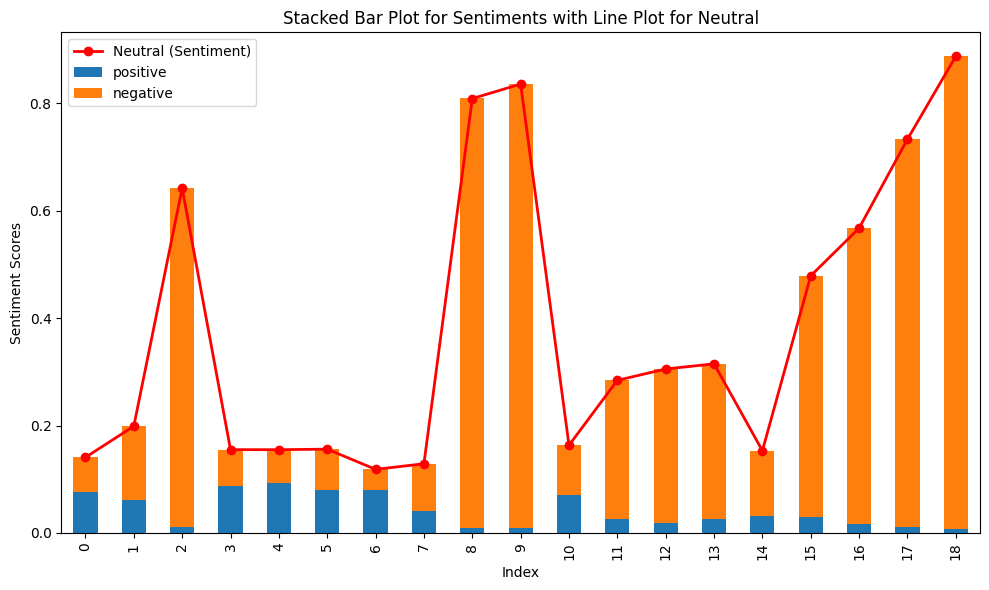

In [140]:
text = thread_df["text"][1]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 2: The root responds to the attack


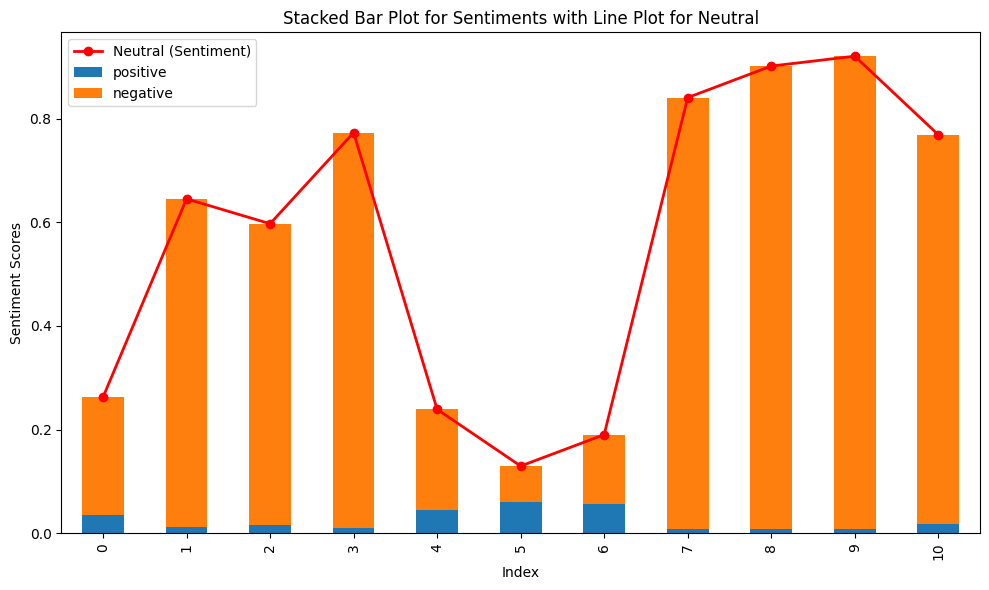

In [136]:
text = thread_df["text"][4]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 3: counter attack against the root

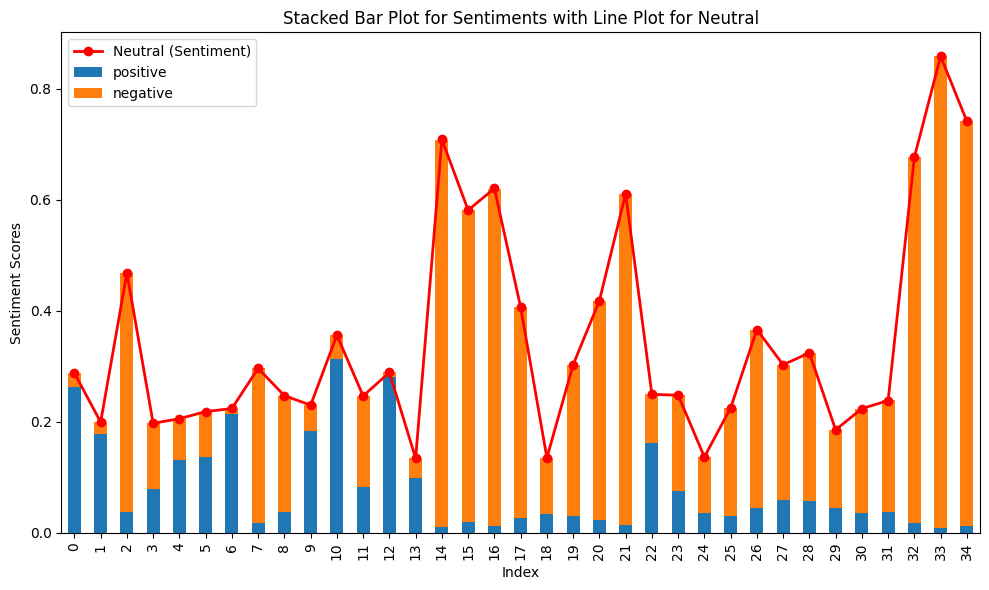

In [137]:
text = thread_df["text"][5]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 4: root submits to the arguments of the attacker

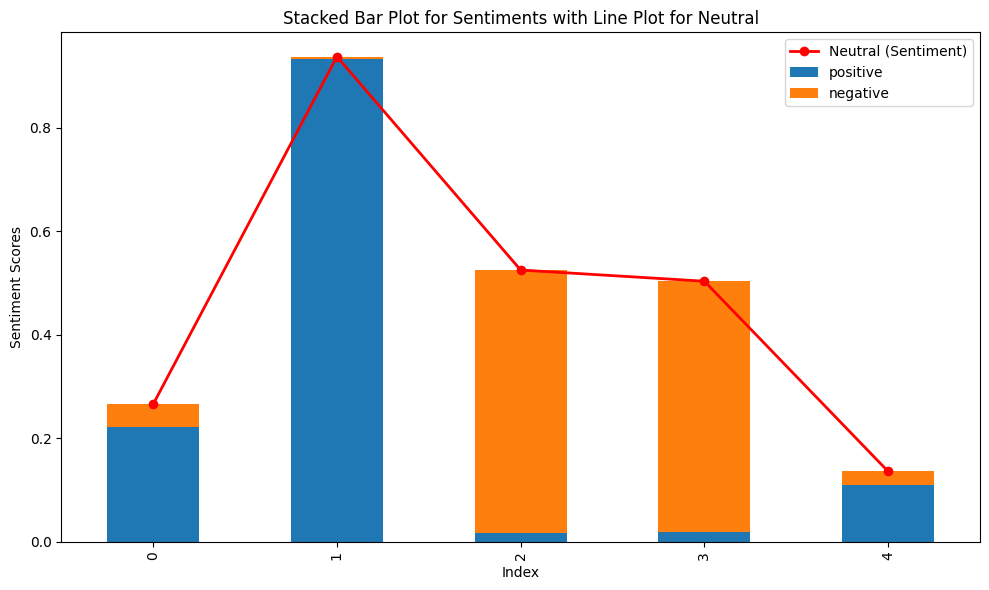

In [142]:
text = thread_df["text"][7]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Example of direct aggrement with the root

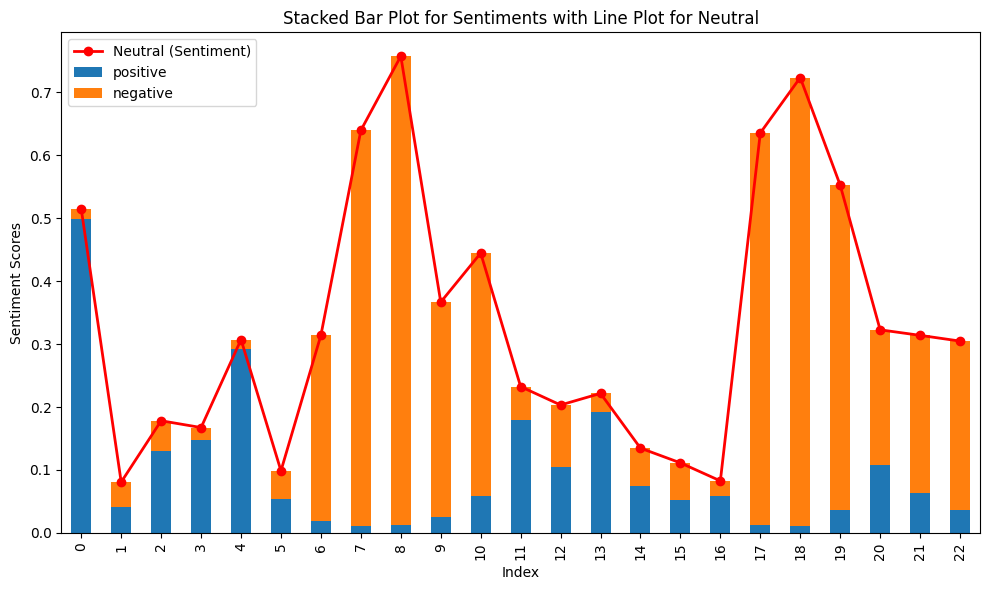

In [144]:
text = thread_df["text"][2]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")